In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tools import pickle_in
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load test samples
samples_g_1, samples_c_1, samples_w_1 = pickle_in("test_samples/samples_1.pickle")
samples_g_2, samples_c_2, samples_w_2 = pickle_in("test_samples/samples_low_var.pickle")
samples_g_3, samples_c_3, samples_w_3 = pickle_in("test_samples/samples_high_dim.pickle")

from covariance import logPr, logX_cov, logX_mean, logX_model

`covariance.py` contains the necessary functions for this approach  
`logX_mean(samples, iteration)`
returns vector $\bm{\mu}$ at iteration $k$\, where $\bm{\mu}$ is the expected value of $X$ at the $n_{live}$ iterations
$$\bm{\mu}=(E[\log X_\text{live}^{(1)}],  \cdots, E[\log X_\text{live}^{(n_{\text{live}})}])$$
`logX_cov(samples, iteration)` likewise returns the covariance matrix between the areas of the $n_\text{live}$ points;
$$\bm{\Sigma}(\log X_i, \log X_j)$$

**TODO** Really want $\Sigma^{-1}$, implent this using Cholesky

`logPr(logX, mean, cov_inv)` returns probability of getting $\log X$, given their expected values and covariance - this is what we want to optimise

In [2]:
import numba as nb
@nb.jit(nopython=True)
def choleskyL_inv(nlive_list):
    """
    Input: list of birth nlive associated with the live points at an iteration
    Output: inverse of covariance matrix between the areas of the nlive points
    """
    nlive = len(nlive_list)
    L_ij_inv = np.zeros((nlive, nlive))
    for i in range(nlive):
        for j in range(nlive):
            if i == j:
                L_ij_inv[i][j] = nlive_list[j]
            elif i == j + 1:
                L_ij_inv[i][j] = -nlive_list[j+1]
    return L_ij_inv

In [20]:
nlive_list = np.arange(100)
%timeit cholesky_inv(nlive_list)

951 µs ± 55.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [43]:
from scipy.optimize import minimize
def optimise_pr(logL, mean, cov_inv, x0):
    def func(theta):
        logX = logX_model(logL, *theta)
        return - logPr(logX, mean, cov_inv) # want to maximise probability <-> minimise negative
    solution = minimize(func, x0, method="SLSQP")
    return solution

In [31]:
def cg_params(samples, iteration):
    """Returns estimated parameters for a given iteration of the samples, using the correlated gaussian
    model of the logX"""
    live_points = samples.live_points(iteration)
    logL = live_points.logL
    mean = logX_mean(samples, iteration)
    cov = logX_cov(samples, iteration)
    cov_inv = np.linalg.inv(cov)
    from analytic_lm import analytic_lm_params
    x0 = analytic_lm_params(samples_g_1, iteration)
    estimated_params = optimise_pr(logL, mean, cov_inv, x0).x
    return estimated_params

In [32]:
# Least squares implementation
def optimise_pr_ls(logL, mean, x0):
    def chisquared(theta):
        logX = logX_model(logL, *theta)
        chisquared = np.sum((logX - mean)**2)
        return chisquared
    solution = minimize(chisquared, x0, method="BFGS")
    return solution

def chisquared(logL, mean, theta):
    logX = logX_model(logL, *theta)
    diff_squared = (logX - mean)**2
    chisquared = np.sum(diff_squared)
    return chisquared

In [49]:
logX_cov(samples_c_1, 5000)

array([[5001., 5001., 5001., ..., 5001., 5001., 5001.],
       [5001., 5002., 5002., ..., 5002., 5002., 5002.],
       [5001., 5002., 5003., ..., 5003., 5003., 5003.],
       ...,
       [5001., 5002., 5003., ..., 9245., 9245., 9245.],
       [5001., 5002., 5003., ..., 9245., 9330., 9330.],
       [5001., 5002., 5003., ..., 9245., 9330., 9979.]])

In [48]:
cg_params(samples_g_1, 5000)

array([-0.19994646,  9.64136877,  0.09835947])

In [33]:
from tools import params_at_iterations
iterations = np.arange(1000, 20000, 1000)
params_estimates = params_at_iterations(samples_c_1, iterations, cg_params)

/home/zixiao/Documents/III/aeons/venv/lib/python3.10/site-packages/anesthetic-2.0.0b12-py3.10.egg/anesthetic/labelled_pandas.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/zixiao/Documents/III/aeons/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration 1000 complete
Iteration 2000 complete
Iteration 3000 complete
Iteration 4000 complete
Iteration 5000 complete
Iteration 6000 complete
Iteration 7000 complete
Iteration 8000 complete
Iteration 9000 complete
Iteration 10000 complete
Iteration 11000 complete
Iteration 12000 complete
Iteration 13000 complete
Iteration 14000 complete
Iteration 15000 complete


KeyboardInterrupt: 

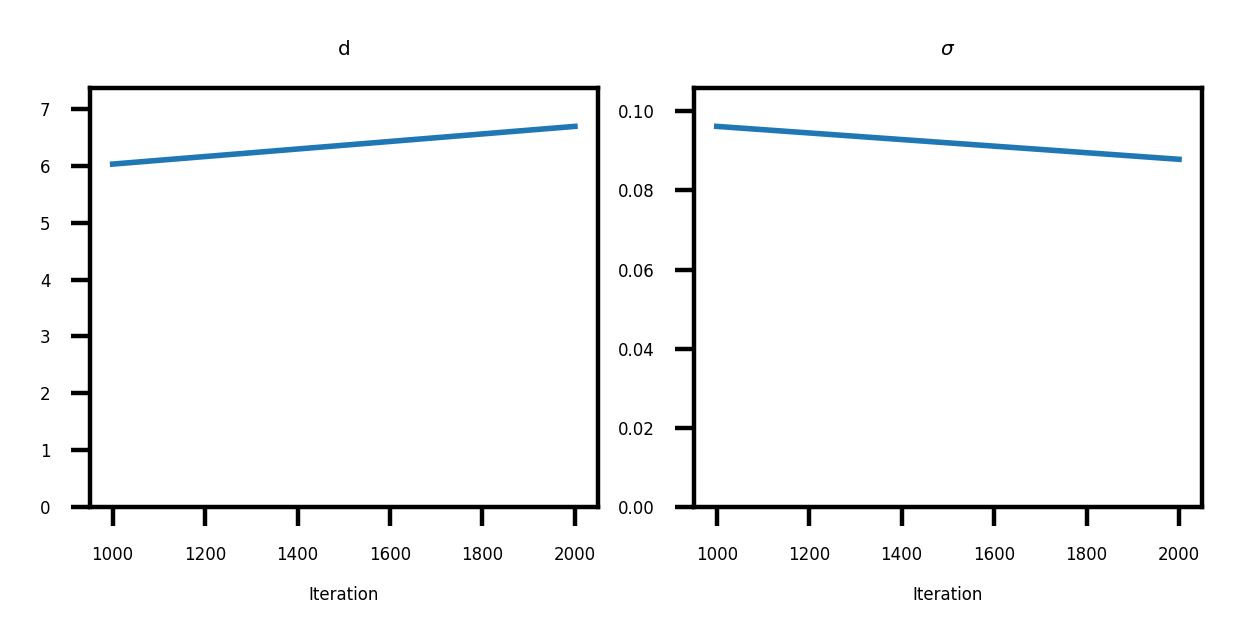

In [29]:
from tools import plot_params
plot_params(iterations, params_estimates, fontsize=3, figsize=(3,1.5))